In [22]:
# Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 


### Additional Utility Functions 

In [23]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [24]:
# First, look at everything.
from subprocess import check_output
print(check_output(["ls", "./sign_data/sign_data"]).decode("utf8"))

test
test_data.csv
train
train_data.csv



In [4]:
class Config():
    training_dir = "./sign_data/sign_data/train"
    testing_dir = "./sign_data/sign_data/test"
    train_batch_size = 32
    train_number_epochs = 10

In [5]:
training_dir="./sign_data/sign_data/train"
training_csv="./sign_data/sign_data/train_data.csv"
testing_csv="./sign_data/sign_data/test_data.csv"
testing_dir="./sign_data/sign_data/test"

In [25]:
RESCALE_SIZE = 224
DATA_MODES = ['train', 'vis', 'test']

In [55]:
class SiameseNetworkDataset():
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0.load()
        img1.load()

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [73]:
transform = transforms.Compose([
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [74]:
siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,transform=transform)
vis_dataset = SiameseNetworkDataset(training_csv,
                                    training_dir,
                                    transform=transforms.Compose([
                                        transforms.Resize((105,105)),
                                        transforms.ToTensor()
                                    ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


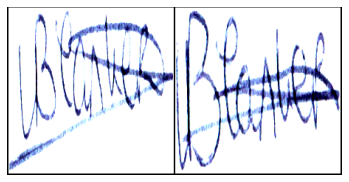

[[0.]]


In [99]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=1)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Siamese Network Definition

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.resnet = models.resnet18(pretrained=False)
        set_parameter_requires_grad(self.resnet)
        num_ftrs = self.resnet.fc.in_features

        self.fc1 = nn.Sequential(
                nn.Linear(num_ftrs, 512),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=0.5),
                nn.Linear(512, 128),
                nn.ReLU(inplace=True),
                nn.Linear(128,2)
            )
        
  
    def forward_once(self, x):
        # Forward pass 
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


### Loss Function

In [10]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

### Train the Model

In [11]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=Config.train_batch_size)

In [12]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

Yes


In [13]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
# optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)
optimizer = optim.AdamW(net.parameters(), lr=0.0001)

In [14]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

Epoch number 0
 Current loss 2.615476608276367

Epoch number 0
 Current loss 1.3957955837249756

Epoch number 0
 Current loss 1.0433372259140015

Epoch number 0
 Current loss 1.051736831665039

Epoch number 0
 Current loss 1.1566581726074219

Epoch number 0
 Current loss 1.3260910511016846

Epoch number 0
 Current loss 1.193235158920288

Epoch number 0
 Current loss 1.1376304626464844

Epoch number 0
 Current loss 1.1494426727294922

Epoch number 0
 Current loss 1.1411750316619873

Epoch number 0
 Current loss 0.9959088563919067

Epoch number 0
 Current loss 1.3266289234161377

Epoch number 0
 Current loss 1.0456691980361938

Epoch number 0
 Current loss 1.1499037742614746

Epoch number 0
 Current loss 1.1994340419769287

Epoch number 1
 Current loss 1.1862637996673584

Epoch number 1
 Current loss 1.3749946355819702

Epoch number 1
 Current loss 1.3102670907974243

Epoch number 1
 Current loss 1.367385745048523

Epoch number 1
 Current loss 1.1672725677490234

Epoch number 1
 Current 

In [21]:
# # Load the saved model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SiameseNetwork().to(device)
# model.load_state_dict(torch.load("model.pt"))

FileNotFoundError: [Errno 2] No such file or directory: 'model.pt'

In [16]:
# Load the test dataset
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

In [17]:
from tqdm import tqdm

In [18]:
targets = []
predictions = []
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
threshhold = torch.FloatTensor([0.7]).cuda()
for i, data in enumerate(tqdm(test_dataloader)):
    # print(data[0].shape)
    # print(data[1].shape)
    # print(data[2])
    x0, x1 , label = data
    output1,output2 = model(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    if label==list_0:
        # label="Orginial"
        targets.append(1)
    else:
        # label="Forged"
        targets.append(0)
    
    if eucledian_distance < threshhold:
        # label="Orginial"
        predictions.append(1)
    else:
        # label="Forged"
        predictions.append(0)



    # print(output1, output2, targets, eucledian_distance, eucledian_distance > threshhold)
    # print(predictions, targets)

    # break




100%|██████████| 5747/5747 [01:34<00:00, 60.95it/s]


In [19]:
n_predictions = np.array(predictions)
n_targets = np.array(targets)
(n_predictions == n_targets).astype('int').sum()/len(n_predictions)

0.49973899425787366

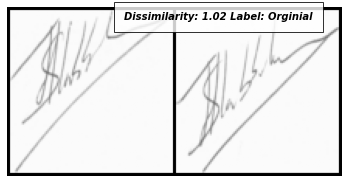

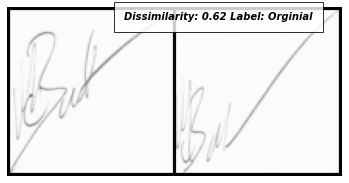

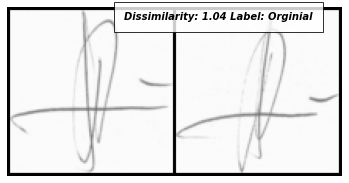

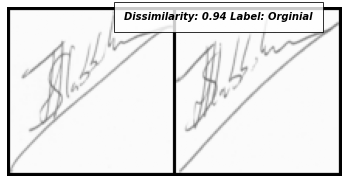

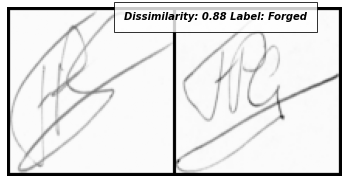

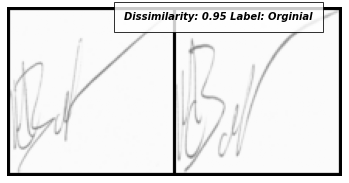

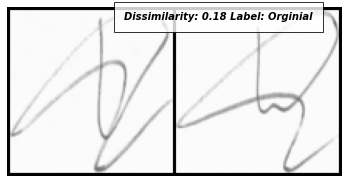

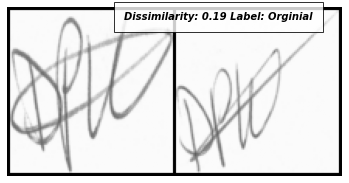

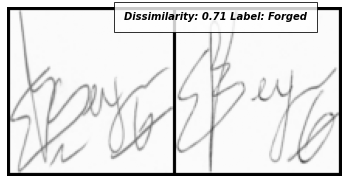

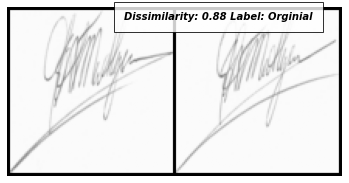

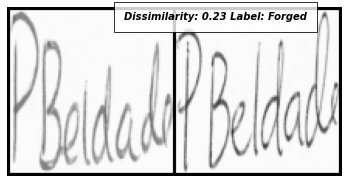

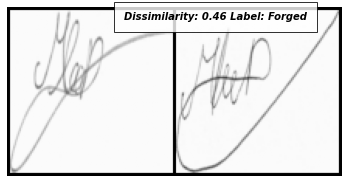

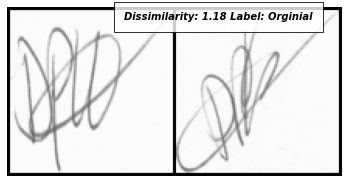

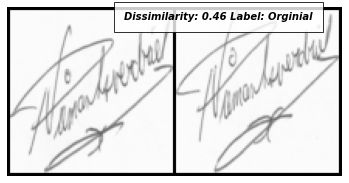

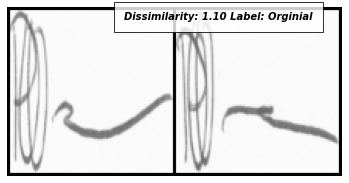

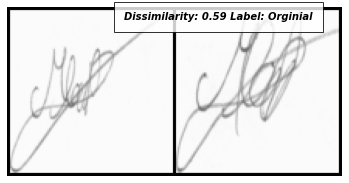

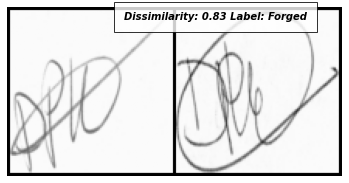

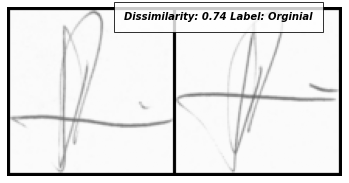

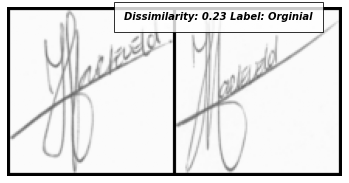

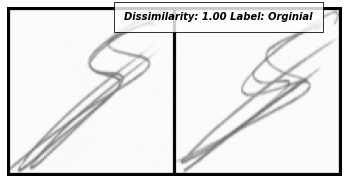

In [21]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

In [ ]:
# Gridsearch границы forged/original
# tiplet loss
# accuracy
# concat datasets

## Final Touch 

Thats it guys ! I am limited by time , computational power and knowledge .to get standard accuracy . But anyway this is the working code of Siamese Neural Network and you can try it for your own applications and dataset.

Paper Reference: https://arxiv.org/pdf/1707.02131.pdf

Thanks to Gupta Blog : https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e